# Calculate wind speed

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "3:00:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    processes=cores,
    job_extra_directives=[
        "-q normal",
        "-P dt6",
        "-l ncpus="+str(cores),
        "-l mem="+str(memory),
        "-l storage=gdata/w42+gdata/rt52+gdata/ob53+scratch/w42"
    ],
    local_directory="$TMPDIR",
    job_directives_skip=["select"]
)

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.1:36491,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

In [6]:
%cd /g/data/w42/dr6273/work/wind_drought

# import functions as fn

/g/data/w42/dr6273/work/wind_drought


In [7]:
# %load_ext autoreload
# %autoreload 2

In [8]:
barra_path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/20min/"
write_path = "/scratch/w42/dr6273/BARRA-C2/"

# Compute wind speed by year

In [9]:
def windspeed(u, v):
    """
    Compute windspeed from u and v
    
    u: array of zonal wind
    v: array of meridional wind
    """
    return np.sqrt(u ** 2 + v ** 2)

In [10]:
def open_hourly(fp, lat_slice=slice(-45, -10), lon_slice=slice(110, 155), lat_name="lat", lon_name="lon"):
    """
    Open multiple hourly files and preprocess to region.
    
    fp: str, path to file. Should not include files, only the path to dir.
    lat_slice, lon_slice: slice of lat/lon to subset
    lat_name, lon_name: names of lat/lon coords.
    """
    def preprocess(ds):
        ds = ds.rename({lat_name: "lat"})
        ds = ds.rename({lon_name: "lon"})
        ds = ds.sel(lon=lon_slice, lat=lat_slice)
        return ds.astype("float32")
    
    ds = xr.open_mfdataset(
        fp,
        preprocess=preprocess,
        chunks={"time": "200MB"},
        concat_dim="time",
        combine="nested",
        compat="override",
        coords="minimal",
        data_vars="minimal",
        # parallel=True
    )
    return ds

In [11]:
def get_filename(variable, frequency, year, month):
    """
    Return BARRA-C2 AUST-04 historical data filepaths
    
    variable: str, variable name e.g. ua100m
    frequency: str, timestep e.g. 20min, 1hr
    year: str
    month: str, month in format '01', '02', ..., '12'
    """
    file_template = variable + "_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_" + frequency + "_"
    return barra_path + variable + "/latest/" + file_template + year + month + "-" + year + month + ".nc"

In [12]:
years = range(1979, 2025)
freq = "20min"
month_str = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

In [13]:
# client.restart()

In [14]:
years[19:]

range(1998, 2025)

In [15]:
for year in years[19:]:
    if year % 5 == 0:
        print(year)
        
        # u100 = open_hourly(
        #     [get_filename("ua100m", freq, str(year), m) for m in month_str[:2]]
        # )
        # v100 = open_hourly(
        #     [get_filename("va100m", freq, str(year), m) for m in month_str[:2]]
        # )
        
    monthly_arrays = []
    for month in month_str:
        
        u100 = open_hourly(
            get_filename("ua100m", freq, str(year), month)
        )
        v100 = open_hourly(
            get_filename("va100m", freq, str(year), month)
        )
        w100 = windspeed(
            u100.rename({"ua100m": "w100m"}),
            v100.rename({"va100m": "w100m"})
        )
        w100 = w100.chunk({"time": 3*24*31, "lat": 100, "lon": 100})
        
        # monthly_arrays.append(w100)
        
        encoding = {
            "w100m": {"dtype": "float32"}
        }
        
        if month == "01":
            w100.to_zarr(
                write_path + "derived/wind_speed/w100m/w100m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
                mode="w",
                encoding=encoding,
                consolidated=True,
                # safe_chunks=False
            )
        else:
            w100.to_zarr(
                write_path + "derived/wind_speed/w100m/w100m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
                mode="a",
                append_dim="time",
                consolidated=True,
                # encoding=encoding,
                # safe_chunks=False
            )
        
#     w100 = xr.concat(monthly_arrays, dim="time")
#     w100 = w100.chunk({"time": 3*24*7*6, "lat": 100, "lon": 100})
    
#     encoding = {
#         "w100m": {"dtype": "float32"}
#     }
#     if year == years[0]:
#         w100.to_zarr(
#             write_path + "derived/wind_speed/w100m/w100m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
#             mode="w",
#             encoding=encoding,
#             consolidated=True,
#             safe_chunks=False
#         )
#     else:
#         w100.to_zarr(
#             write_path + "derived/wind_speed/w100m/w100m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
#             mode="a",
#             append_dim="time",
#             encoding=encoding,
#             safe_chunks=False
#         )
        

2000
2005
2010
2015
2020


In [16]:
years[32:]

range(2011, 2025)

In [17]:
for year in years[32:]:
    if year % 5 == 0:
        print(year)
        
    monthly_arrays = []
    for month in month_str:
        
        u = open_hourly(
            get_filename("ua150m", freq, str(year), month)
        )
        v = open_hourly(
            get_filename("va150m", freq, str(year), month)
        )
        w = windspeed(
            u.rename({"ua150m": "w150m"}),
            v.rename({"va150m": "w150m"})
        )
        w = w.chunk({"time": 3*24*31, "lat": 100, "lon": 100})
                
        encoding = {
            "w150m": {"dtype": "float32"}
        }
        
        if month == "01":
            w.to_zarr(
                write_path + "derived/wind_speed/w150m/w150m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
                mode="w",
                encoding=encoding,
                consolidated=True,
                # safe_chunks=False
            )
        else:
            w.to_zarr(
                write_path + "derived/wind_speed/w150m/w150m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
                mode="a",
                append_dim="time",
                consolidated=True,
                # encoding=encoding,
                # safe_chunks=False
            )
        
#     w100 = xr.concat(monthly_arrays, dim="time")
#     w100 = w100.chunk({"time": 3*24*7*6, "lat": 100, "lon": 100})
    
#     encoding = {
#         "w100m": {"dtype": "float32"}
#     }
#     if year == years[0]:
#         w100.to_zarr(
#             write_path + "derived/wind_speed/w100m/w100m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
#             mode="w",
#             encoding=encoding,
#             consolidated=True,
#             safe_chunks=False
#         )
#     else:
#         w100.to_zarr(
#             write_path + "derived/wind_speed/w100m/w100m_BARRA-C2_" + freq + "_" + str(year) + ".zarr",
#             mode="a",
#             append_dim="time",
#             encoding=encoding,
#             safe_chunks=False
#         )
        

2015
2020


In [72]:
w100 = xr.open_zarr(
    write_path + "derived/wind_speed/w100m/w100m_BARRA-C2_" + freq + "_" + str(year) + ".zarr"
)

In [73]:
w100

<xarray.Dataset> Size: 17GB
Dimensions:  (lat: 875, lon: 1125, time: 4248)
Coordinates:
    crs      int32 4B ...
    height   float64 8B ...
  * lat      (lat) float64 7kB -44.97 -44.93 -44.89 ... -10.09 -10.05 -10.01
  * lon      (lon) float64 9kB 110.0 110.1 110.1 110.1 ... 154.9 154.9 155.0
  * time     (time) datetime64[ns] 34kB 1979-01-01 ... 1979-02-28T23:40:00
Data variables:
    w100m    (time, lat, lon) float32 17GB dask.array<chunksize=(2232, 100, 100), meta=np.ndarray>

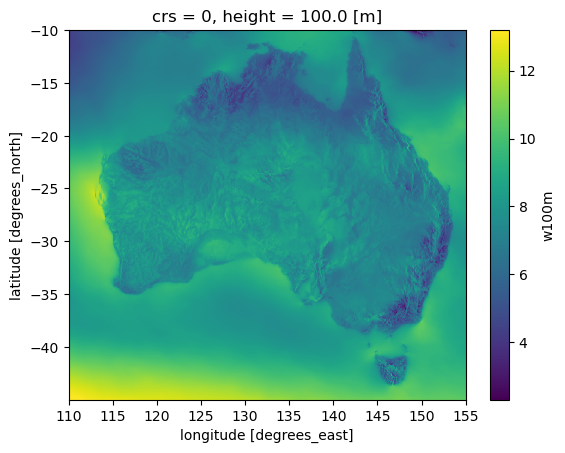

In [23]:
w100.w100m.mean("time").plot()

# Close cluster

In [59]:
client.close()
cluster.close()